In [ ]:
!pip install optuna

In [ ]:
import gym
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import random
from itertools import count
import torch.nn.functional as F
import matplotlib.pyplot as plt
import optuna
# from tensorboardX import SummaryWriter


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(6, 64)
        self.relu = nn.ReLU()
        self.fc_value = nn.Linear(64, 256)
        self.fc_adv = nn.Linear(64, 256)

        self.value = nn.Linear(256, 1)
        self.adv = nn.Linear(256, 3)

    def forward(self, state):
        y = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        advAverage = torch.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage

        return Q

    def forward_2(self, state):
        y = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        advMax = torch.max(adv, dim=1, keepdim=True).values
        Q = value + adv - advMax

        return Q

    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item()

    def select_action_2(self, state):
        with torch.no_grad():
            Q = self.forward_2(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item()


class Memory(object):
    def __init__(self, memory_size: int) -> None:
        self.memory_size = memory_size
        self.buffer = deque(maxlen=self.memory_size)

    def add(self, experience) -> None:
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size: int, continuous: bool = True):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if continuous:
            rand = random.randint(0, len(self.buffer) - batch_size)
            return [self.buffer[i] for i in range(rand, rand + batch_size)]
        else:
            indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
            return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()


Defining the environment

In [ ]:
env = gym.make('Acrobot-v1')
onlineQNetwork = QNetwork().to(device)

Defining the objective and train functions

In [ ]:
class Training:
    def __init__(self, environment,action_selection):
        self.environment = environment
        self.action_selection=action_selection

    def objective(self, trial):
        params = {
            'initial_epsilon': trial.suggest_loguniform('initial_epsilon', 0.1, 0.2),
            'lr': trial.suggest_loguniform('lr', 1e-5, 1e-4),
            'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
            'replay_size': trial.suggest_categorical('replay_size', [50000, 75000, 100000]),
        }
        seed = 1
        episode_rewards = self.train(seed, params, break_at_threshold=True, action_selection=onlineQNetwork.select_action)
        return np.mean(episode_rewards)

    def train(self, seed, params, break_at_threshold=False, action_selection=None):
        if action_selection is None:
            action_selection = self.action_selection
        env = self.environment
        env.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        # onlineQNetwork = QNetwork().to(device)
        targetQNetwork = QNetwork().to(device)
        targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
        optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=params['lr'])

        GAMMA = 0.99
        EXPLORE = 20000
        INITIAL_EPSILON = params['initial_epsilon']
        FINAL_EPSILON = 0.0001
        REPLAY_MEMORY = params['replay_size']
        BATCH = params['batch_size']
        MAX_EPISODES = 500
        UPDATE_STEPS = 4

        memory_replay = Memory(REPLAY_MEMORY)

        epsilon = INITIAL_EPSILON
        learn_steps = 0
        begin_learn = False

        episode_rewards = []
        running_reward = -500
        counter = 0

        for epoch in range(MAX_EPISODES):
            state = env.reset()
            episode_reward = 0
            done = False
            while not done:
                p = random.random()
                if p < epsilon:
                    action = random.randint(0, 1)
                else:
                    tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
                    action = action_selection(tensor_state)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward

                memory_replay.add((state, next_state, action, reward, done))

                if memory_replay.size() > 128:
                    if not begin_learn:
                        print('learn begin!')
                        begin_learn = True
                    learn_steps += 1
                    if learn_steps % UPDATE_STEPS == 0:
                        targetQNetwork.load_state_dict(onlineQNetwork.state_dict())

                    batch = memory_replay.sample(BATCH, False)
                    batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)

                    batch_state = torch.FloatTensor(batch_state).to(device)
                    batch_next_state = torch.FloatTensor(batch_next_state).to(device)
                    batch_action = torch.FloatTensor(batch_action).unsqueeze(1).to(device)
                    batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
                    batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

                    with torch.no_grad():
                        onlineQ_next = onlineQNetwork(batch_next_state)
                        targetQ_next = targetQNetwork(batch_next_state)
                        online_max_action = torch.argmax(onlineQ_next, dim=1, keepdim=True)
                        y = batch_reward + (1 - batch_done) * GAMMA * targetQ_next.gather(1, online_max_action.long())

                    loss = F.mse_loss(onlineQNetwork(batch_state).gather(1, batch_action.long()), y)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    if epsilon > FINAL_EPSILON:
                        epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

                state = next_state

            episode_rewards.append(episode_reward)

            running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

            if running_reward > env.spec.reward_threshold:
                if counter < 1:
                    print("Environment Solved. Running Reward is now {}".format(running_reward))
                    counter += 1
                if break_at_threshold:
                    break

            if epoch % 100 == 0:
                print('Seed: {}, Epoch: {}\tMoving average score: {:.2f}\t'.format(seed, epoch, episode_reward))

        return episode_rewards

Tuning Hyperparameters

In [ ]:

TrainType1=Training(env,onlineQNetwork.select_action)
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(lambda trial: TrainType1.objective(trial), n_trials=3)

# Print the best parameters found
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Running the experiment 5 times 

In [ ]:
num_seeds = 5
all_episode_rewards = []

for seed in range(num_seeds):
    episode_rewards = TrainType1.train(seed,trial.params)
    all_episode_rewards.append(episode_rewards)

# Calculate mean and variance across runs for each episode
mean_rewards_1 = np.mean(all_episode_rewards, axis=0)
variance_rewards_1 = np.var(all_episode_rewards, axis=0)


## Type 2 DQN


Tuning Hyperparamters

In [ ]:
onlineQNetwork = QNetwork().to(device)
TrainType2=Training(env,onlineQNetwork.select_action_2)
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(lambda trial: TrainType2.objective(trial), n_trials=3)

# Print the best parameters found
print("Best trial:")
trial2 = study.best_trial
print("  Value: ", trial2.value)
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
num_seeds = 5
all_episode_rewards_2 = []


for seed in range(num_seeds):
    episode_rewards = TrainType2.train(seed,trial2.params)
    all_episode_rewards_2.append(episode_rewards)

# Calculate mean and variance across runs for each episode
mean_rewards_2 = np.mean(all_episode_rewards_2, axis=0)
variance_rewards_2 = np.var(all_episode_rewards_2, axis=0)



Plotting and comparing the two reward curves

In [ ]:
# Calculate overall variances
overall_variance_1 = np.mean(variance_rewards_1)
overall_variance_2 = np.mean(variance_rewards_2)

if overall_variance_1 > overall_variance_2:
    higher_variance_label = 'Mean Return (Type-1, Var:{:.2f}) higher than (Type-2, Var:{:.2f}) '.format(overall_variance_1,overall_variance_2)
elif overall_variance_1 < overall_variance_2:
    higher_variance_label = 'Mean Return (Type-2) has higher variance (Variance: {:.2f})'.format(overall_variance_2)
else:
    higher_variance_label = 'Both sets have the same variance (Variance: {:.2f})'.format(overall_variance_1)

Plotting

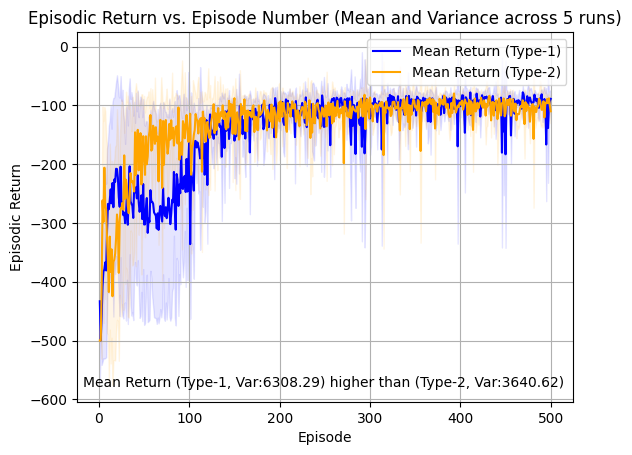

In [ ]:
# Plot mean episodic return with shaded regions representing variance for variant 1
plt.plot(range(1, len(mean_rewards_1) + 1), mean_rewards_1, label='Mean Return (Type-1)', color='blue')
plt.fill_between(range(1, len(mean_rewards_1) + 1), mean_rewards_1 - np.sqrt(variance_rewards_1),
                 mean_rewards_1 + np.sqrt(variance_rewards_1), color='blue', alpha=0.1)

# Plot mean episodic return with shaded regions representing variance for variant 2
plt.plot(range(1, len(mean_rewards_2) + 1), mean_rewards_2, label='Mean Return (Type-2)', color='orange')
plt.fill_between(range(1, len(mean_rewards_2) + 1), mean_rewards_2 - np.sqrt(variance_rewards_2),
                 mean_rewards_2 + np.sqrt(variance_rewards_2), color='orange', alpha=0.1)

plt.text(0.5, 0.05, higher_variance_label, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


plt.xlabel('Episode')
plt.ylabel('Episodic Return')
plt.title('Episodic Return vs. Episode Number (Mean and Variance across 5 runs)')
plt.legend()
plt.grid(True)
plt.show()

Plotting moving average for last 100 episodes

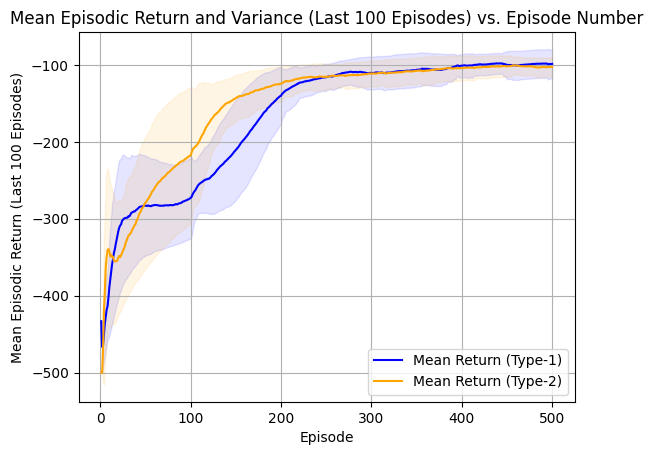

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to calculate mean average and variance for last 100 episodes
def calculate_last_100_stats(data):
    last_100_mean = np.mean(data[-100:])
    last_100_var = np.var(data[-100:])
    return last_100_mean, last_100_var

# Initialize lists to hold mean rewards and variances for both types
mean_rewards_1_last_100 = []
variance_rewards_1_last_100 = []
mean_rewards_2_last_100 = []
variance_rewards_2_last_100 = []

# Iterate over episodes
for episode in range(1, len(mean_rewards_1) + 1):
    # Calculate mean average and variance for last 100 episodes for both types
    mean_1_last_100, var_1_last_100 = calculate_last_100_stats(mean_rewards_1[:episode])
    mean_2_last_100, var_2_last_100 = calculate_last_100_stats(mean_rewards_2[:episode])

    # Append to lists
    mean_rewards_1_last_100.append(mean_1_last_100)
    variance_rewards_1_last_100.append(var_1_last_100)
    mean_rewards_2_last_100.append(mean_2_last_100)
    variance_rewards_2_last_100.append(var_2_last_100)

# Plot mean average and variance for last 100 episodes
plt.plot(range(1, len(mean_rewards_1_last_100) + 1), mean_rewards_1_last_100, label='Mean Return (Type-1)', color='blue')
plt.fill_between(range(1, len(mean_rewards_1_last_100) + 1), mean_rewards_1_last_100 - np.sqrt(variance_rewards_1_last_100),
                 mean_rewards_1_last_100 + np.sqrt(variance_rewards_1_last_100), color='blue', alpha=0.1)

plt.plot(range(1, len(mean_rewards_2_last_100) + 1), mean_rewards_2_last_100, label='Mean Return (Type-2)', color='orange')
plt.fill_between(range(1, len(mean_rewards_2_last_100) + 1), mean_rewards_2_last_100 - np.sqrt(variance_rewards_2_last_100),
                 mean_rewards_2_last_100 + np.sqrt(variance_rewards_2_last_100), color='orange', alpha=0.1)

plt.xlabel('Episode')
plt.ylabel('Mean Episodic Return (Last 100 Episodes)')
plt.title('Mean Episodic Return and Variance (Last 100 Episodes) vs. Episode Number')
plt.legend()
plt.grid(True)
plt.show()
